In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import random
from sklearn.metrics import accuracy_score
import copy
import cv2

In [2]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()
print(x_train_full.shape)
print(x_test_full.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
classes = [0,1,2,3]

train_filter = np.where((y_train_full == classes[0]) | (y_train_full == classes[1]) | 
                        (y_train_full == classes[2]) | (y_train_full == classes[3]))

test_filter = np.where((y_test_full == classes[0]) | (y_test_full == classes[1]) | 
                        (y_test_full == classes[2]) | (y_test_full == classes[3]))

x_train, y_train = x_train_full[train_filter], y_train_full[train_filter]
x_test, y_test = x_test_full[test_filter], y_test_full[test_filter]

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24754, 28, 28)
(24754,)
(4157, 28, 28)
(4157,)


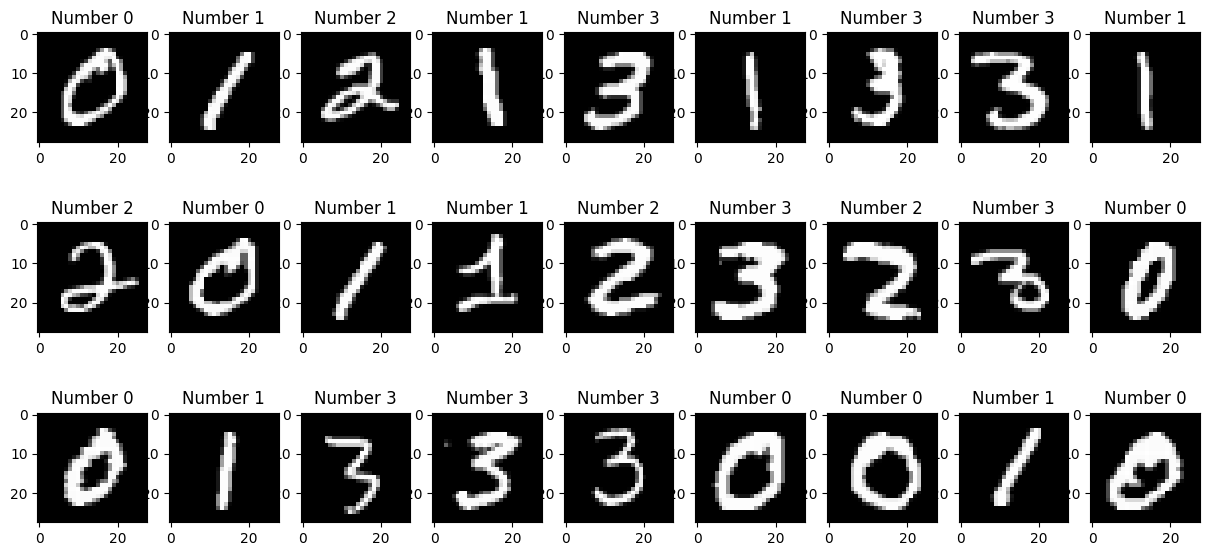

In [5]:
plt.figure(figsize=(15, 7))
for i in range(27):
  plt.subplot(3, 9, i + 1)
  plt.title("Number {0}".format(y_train[i]))
  plt.imshow(x_train[i], cmap = 'gray')

In [6]:
def resize(data):
     resized_data = []
     for img in data:
            resized_img = cv2.resize(img, (20, 20))
            resized_data.append(resized_img)
     return resized_data

x_train = resize(x_train)
x_test = resize(x_test)

x_train = np.array(x_train, np.float32) / 255.0
x_test = np.array(x_test, np.float32) / 255.0

x_train = x_train.reshape([-1, 400])
x_test = x_test.reshape([-1, 400])

y_train = np.array(y_train, np.int32)
y_test = np.array(y_test, np.int32)

In [7]:
def y_to_arrays(y_t):
  y_arrays = []
  for y in y_t:
    y_arr = np.zeros(np.array(y_t).max() + 1, dtype = int)
    y_arr = y_arr.tolist()
    y_arr[y] = 1
    y_arrays.append(y_arr)
  return y_arrays

def arrays_to_y(y_arrays):
  y_t = []
  for y in y_arrays:
    y_t.append(np.argmax(y))
  return y_t

print(y_to_arrays(y_train[:10]))
print(arrays_to_y(y_to_arrays(y_train[:10])))

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0]]
[0, 1, 2, 1, 3, 1, 3, 3, 1, 2]


In [8]:
def fun_sigmoid(s):
  return 1 / (1 + np.exp(-s))

def fun_der_sigm(s):
  return fun_sigmoid(s) * (1 - fun_sigmoid(s))

def err_acc(pred_y, tst_y, eps):
  hit = 0
  for i in range(len(tst_y)):
    if(np.abs(pred_y[i] - tst_y[i]) < eps): hit = hit + 1
  return hit / len(tst_y)

class Neuron:
  def __init__(self, weightsCount, number = None):
    if number is None: 
      self.weights = []
      for i in range(weightsCount):
        self.weights.append(5 - random.random() * 10)
    else:
      self.weights = [] 
      for i in range(weightsCount):
        self.weights.append(number)

  def get_sum(self, x):
    sum = 0
    for i in range(len(self.weights)):
      sum += self.weights[i] * x[i]
    return sum

  def feed(self, x):
    y = fun_sigmoid(self.get_sum(x))
    return y

  def print_params(self):
    n_str = ''
    for i in range(len(self.weights)):
      n_str += str(self.weights[i]) + " "
    print(n_str + str(self.bias))

def err_los_mc(tst_y, pred_y):
  loss = 0
  for i in range(len(tst_y)):
    for j in range(len(tst_y[0])):
      loss += np.square(pred_y[i][j] - tst_y[i][j])
  loss = np.sqrt(loss) / len(tst_y)
  return loss

def add_bias_to_data(data):
  data_with_bias = copy.deepcopy(data)
  for elem in data_with_bias:
#     elem = np.append(elem, 1)
    elem.append(1)
  return data_with_bias

In [9]:
class History:
    def __init__(self, epochs, accs, loss):
        self.epochs = epochs
        self.accs = accs
        self.loss = loss

class NetworkMC:
    def __init__(self, layers):
        self.layers = []
        for i in range(len(layers) - 1):
            layer = []
            for j in range(layers[i + 1]):
                n = Neuron(layers[i] + 1)
                layer.append(n)
            self.layers.append(layer)
        self.history = History([], [], [])

    def predict(self, data):
        data_with_bias = add_bias_to_data(data)
        y_pred = []
        for x in data_with_bias:
            x_old = x
            x_new = []
            for i in range(len(self.layers)):
                for n in self.layers[i]:
                    x_new.append(n.feed(x_old))
                if i < len(self.layers) - 1:
                    x_new.append(1)
                x_old = x_new
                x_new = []
            y_pred.append(x_old)
        return y_pred
    
    def train_full_batch(self, data, y_trues, speed, epochs):
        data_with_bias = add_bias_to_data(data)
        y_trues_arr = y_to_arrays(y_trues) 
        for epoch in range(epochs):
            if (epoch + 1) % (epochs // 10) == 0 or epoch == 0:
                y_preds = self.predict(data)
                err = err_los_mc(y_trues_arr, y_preds)
                acc = err_acc(y_trues, arrays_to_y(y_preds), 0.1)
                self.history.epochs.append(epoch)
                self.history.accs.append(acc)
                self.history.loss.append(err)
                print("Epoch %d err: %.3f, acc: %.3f" % (epoch, err, acc))
            for x, y_true in zip(data_with_bias, y_trues_arr):
                self.grad_iteration(x, y_true, speed)


    def train_stochastic(self, data, y_trues, speed, epochs):
        data_with_bias = add_bias_to_data(data)
        y_trues_arr = y_to_arrays(y_trues) 
        for epoch in range(epochs + 1):
            if (epoch + 1) % (epochs // 10) == 0 or epoch == 0:
                y_preds = self.predict(data)
                err = err_los_mc(y_trues_arr, y_preds)
                acc = err_acc(y_trues, arrays_to_y(y_preds), 0.1)
                self.history.epochs.append(epoch)
                self.history.accs.append(acc)
                self.history.loss.append(err)
                print("Epoch %d err: %.3f, acc: %.3f" % (epoch, err, acc))
            n_rule = np.random.randint(0, len(data_with_bias))
            x = data_with_bias[n_rule]
            y_true = y_trues_arr[n_rule]
            self.grad_iteration(x, y_true, speed)

        

    def grad_iteration(self, x, y_true, speed):
        results = []
        x_old = x
        x_new = []
        for i in range(len(self.layers)):
            for n in self.layers[i]:
                x_new.append(n.feed(x_old))
            if i < len(self.layers) - 1:
                x_new.append(1)
            x_old = x_new
            results.append(x_old)
            x_new = []
    
        # Изменение весов на выходном слое
        grad1 = []
        for j in range(len(results[-1])):
            delta = results[-1][j] - y_true[j]
            grad1.append(delta * fun_der_sigm(results[-1][j]))
            for i in range(len(results[-2])):
                self.layers[-1][j].weights[i] = self.layers[-1][j].weights[i] - speed * grad1[j] * results[-2][i]

        # Изменение весов на скрытых слоях
        for k in range(len(self.layers) - 2, -1, -1):
            grad2 = []
            for i in range(len(results[k])):
                grad_sum = 0
                for j in range(len(self.layers[k + 1])):
                    grad_sum += grad1[j] * self.layers[k + 1][j].weights[i] * fun_der_sigm(results[k][i])
                grad2.append(grad_sum)
            for i in range(len(self.layers[k])):
                if k == 0:
                    for j in range(len(x)):
                        self.layers[k][i].weights[j] = self.layers[k][i].weights[j] - speed * grad2[i] * x[j]
                else:
                    for j in range(len(results[k - 1])):
                        self.layers[k][i].weights[j] = self.layers[k][i].weights[j] - speed * grad2[i] * results[k - 1][j]
            grad1 = grad2
            grad2 = []

In [10]:
network = NetworkMC([400,64,24,4])

network.train_full_batch(x_train[:120].tolist(), y_train[:120].tolist(), 0.01, 100)

Epoch 0 err: 0.152, acc: 0.183
Epoch 9 err: 0.069, acc: 0.692
Epoch 19 err: 0.051, acc: 0.842
Epoch 29 err: 0.046, acc: 0.892
Epoch 39 err: 0.038, acc: 0.933
Epoch 49 err: 0.034, acc: 0.967
Epoch 59 err: 0.032, acc: 0.958
Epoch 69 err: 0.031, acc: 0.967
Epoch 79 err: 0.028, acc: 0.975
Epoch 89 err: 0.024, acc: 0.992
Epoch 99 err: 0.023, acc: 0.992


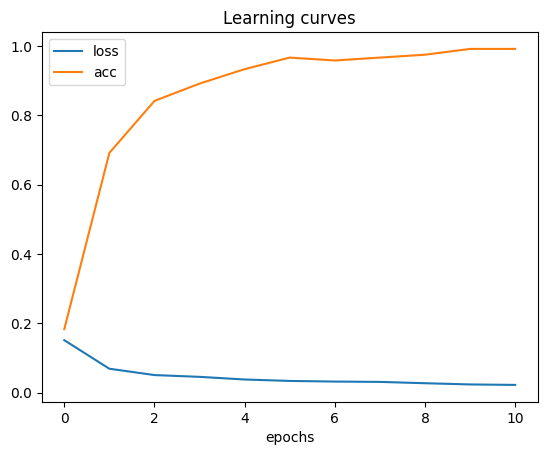

In [11]:
history = network.history
plt.title('Learning curves')
plt.plot(history.loss, label = 'loss')
plt.plot(history.accs, label = 'acc')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [12]:
test_imgs = x_test[:30]

y_pred_multy = network.predict(test_imgs.tolist())
y_pred = arrays_to_y(network.predict(test_imgs.tolist()))
print("acc: " + str(accuracy_score(y_test[:len(test_imgs)], y_pred)))

acc: 0.8666666666666667


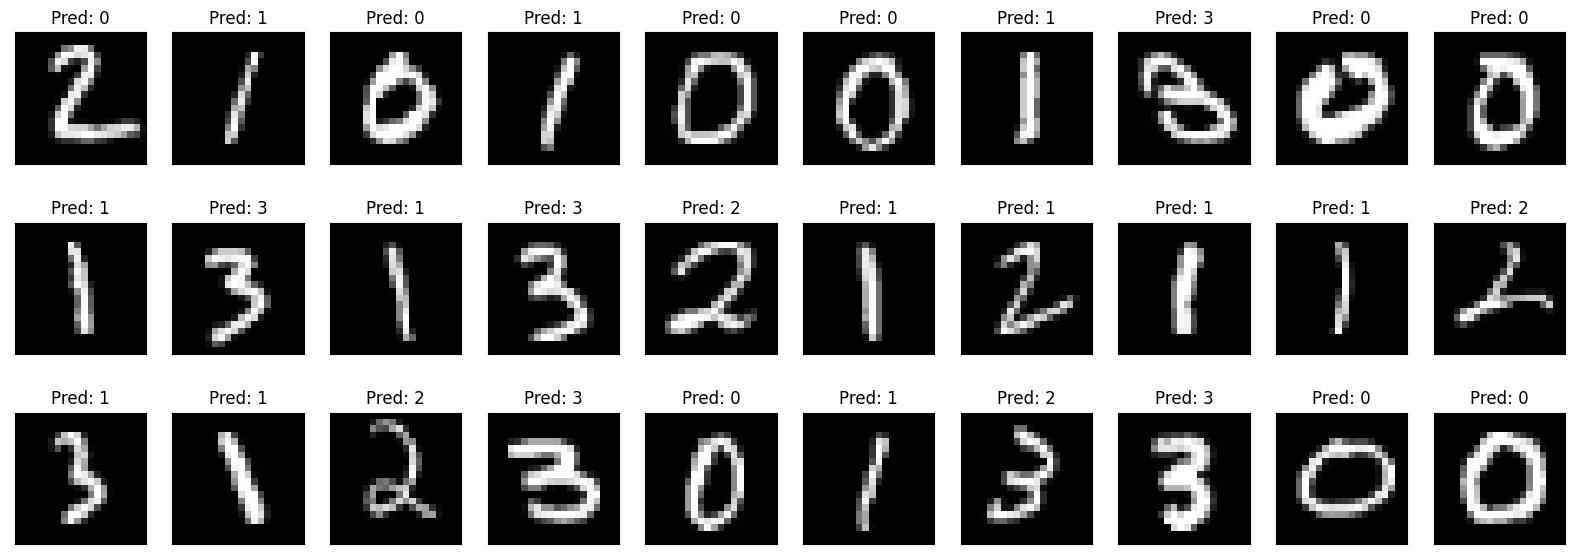

In [14]:
fig = plt.figure(figsize = (20, 7))
for i in np.arange(30):
  ax = fig.add_subplot(3, 10, i + 1, xticks = [], yticks = [])
  plt.imshow(np.reshape(test_imgs[i], [20, 20]), cmap = 'gray', interpolation = 'none')
  ax.set_title("Pred: {}".format(np.argmax(y_pred_multy[i])))